In [76]:
# Module
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats # 확률분포 그래프
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

### 평균과 중앙값으로 windspeed가 0인 것을 대체하는 것은 도움이 되지 않는다.   
## RandomForest Classification Model을 사용.   


In [197]:
# train data를 불러오자
train = pd.read_csv('./data/bike-sharing-demand/train.csv', parse_dates=['datetime']) # datetime 컬럼을 날짜화 시킨다.
train.head() # windspeed가 0인 데이터는 측정을 안했다고 판단 할 수 있다.

# test data를 불러오자
test = pd.read_csv('./data/bike-sharing-demand/test.csv', parse_dates=['datetime']) # datetime 컬럼을 날짜화 시킨다.
test.head() # windspeed가 0인 데이터는 측정을 안했다고 판단 할 수 있다.

# Feature 구성
# datetime data를 분할하여 train data에 추가
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.dayofweek
print(train.shape) # 컬럼이 추가 됨
print(train.info())

# Feature 구성
# datetime data를 분할하여 train data에 추가
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second
test['dayofweek'] = test['datetime'].dt.dayofweek
print(test.shape) # 컬럼이 추가 됨
print(test.info())

(10886, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 19 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
year          10886 non-null int64
month         10886 non-null int64
day           10886 non-null int64
hour          10886 non-null int64
minute        10886 non-null int64
second        10886 non-null int64
dayofweek     10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(15)
memory usage: 1.6 MB
None
(6493, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 16 columns):
dateti

### windspeed값을 보면 숫자가 모두 있는것이 아니고 항목이 정해져있다. == Iris데이터와 동일
### 따라서 리그레션이 아닌 클래시피케이션(분류)을 사용

In [198]:
# Random Forest를 이용하여 0값을 대체
def predict_windspeed(data):
    # windspeed가 0인것과 아닌것 분리
    dataWind0 = data[data['windspeed'] == 0]
    dataWindN0 = data[data['windspeed'] != 0]
    
    # Feature 선택
    #fcol = ['season','weather','humidity','month','temp','year','atemp']
    fcol = ['season','weather','humidity','month','temp','year']
    
    # RandomForest Classification을 사용하려면 windspeed 값을 문자형으로 변경
    dataWindN0['windspeed'] = dataWindN0['windspeed'].astype('str')
    
    # RandomForest
    rfModelWind = RandomForestClassifier()
    
    # fcol에 있는 항목으로 학습
    rfModelWind.fit(dataWindN0[fcol], dataWindN0['windspeed'])
    
    # windspeed가 0인 데이터의 예측
    wind0Values = rfModelWind.predict(X = dataWind0[fcol])
    
    # 예측후에 사용할 dataframe 생성
    predictWind0 = dataWind0
    predictWindN0 = dataWindN0
    
    # 예측값 대입
    predictWind0['windspeed'] = wind0Values
    
    # data 합치기
    data = predictWindN0.append(predictWind0)
    
    # windspeed의 type을 float로 변환
    data['windspeed'] = data['windspeed'].astype('float')
    
    data.reset_index(inplace = True)
    data.drop('index', inplace = True, axis = 1)
    
    return data

## 해결1 test 데이터에 0값처리 하지 않아야 한다!!!

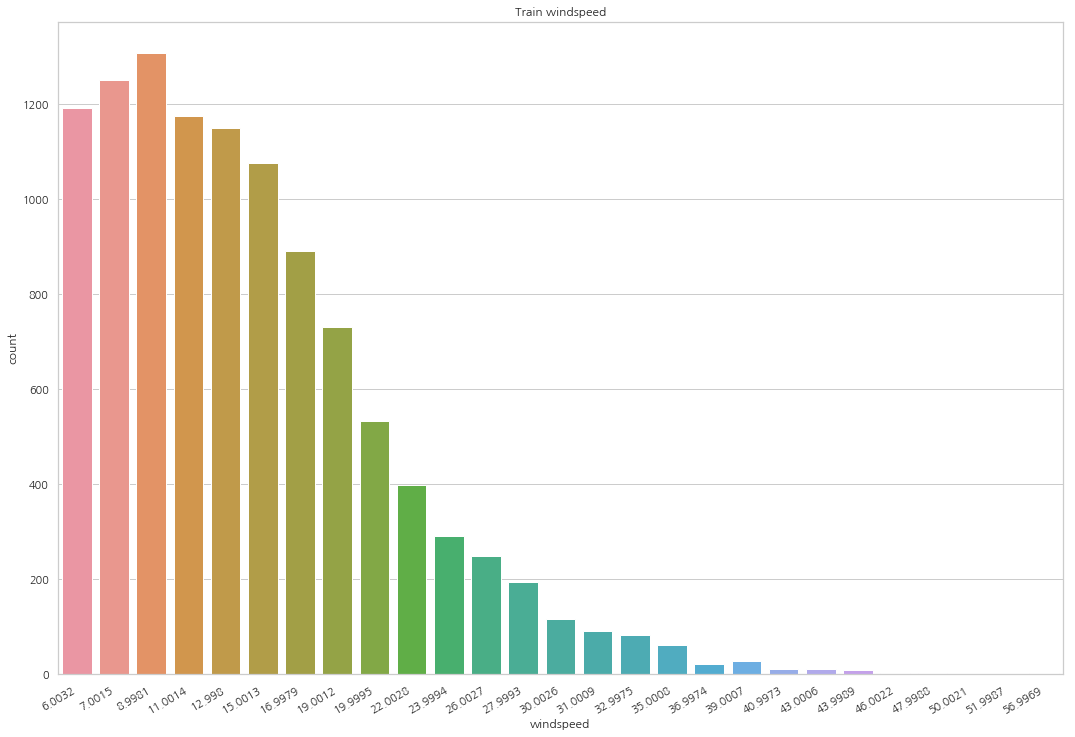

In [199]:
# train dataset중 windspeed가 0인것을 RandomForestClassifier로 대체
train = predict_windspeed(train)

# windspeed가 0값이 많이 보인다.
fig, ax1 = plt.subplots()
fig.set_size_inches(18, 12)

# train dataset 확인
plt.sca(ax1)
plt.xticks(rotation = 30, ha = 'right') # xticks(rotation = 30) -> 30도 돌려라
ax1.set(ylabel = 'Count', title = 'Train windspeed')
sns.countplot(data = train, x = 'windspeed', ax = ax1)

In [200]:
# train데이터중 windspeed가 0인 data 확인
train[train['windspeed'] == 0]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek


# Feature Selection(머신러닝을 위한)
- 신호와 잡음을 구분   
- Feature가 많다고 무조건 좋은 성능을 발휘하는 것은 아니다.   
- Feature를 하나씩 추가 혹은 제거하면서 성능이 좋지 않은 Feature는 제거한다.   

In [201]:
# 연속형 Feature와 범주형 Feature 구분
# 연속형 Feature : temp, humidity, windspeed, atemp
# 범주형 Feature : season, holiday, workingday, weather, dayofweek, month, year, hour
# 범주형 Feature는 Category로 변경 시켜주어야 한다.
categorical_feature_name = \
['season','holiday','workingday','weather','dayofweek','month','year','hour']

for i in categorical_feature_name:
    train[i] = train[i].astype('category')

In [202]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 19 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null category
holiday       10886 non-null category
workingday    10886 non-null category
weather       10886 non-null category
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
year          10886 non-null category
month         10886 non-null category
day           10886 non-null int64
hour          10886 non-null category
minute        10886 non-null int64
second        10886 non-null int64
dayofweek     10886 non-null category
dtypes: category(8), datetime64[ns](1), float64(3), int64(7)
memory usage: 1022.9 KB


# 변경부분

In [203]:
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011,1,1,5,0,0,5
1,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12,24,36,2011,1,1,10,0,0,5
2,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26,30,56,2011,1,1,11,0,0,5


In [204]:
test.tail(15)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,minute,second,dayofweek
6478,2012-12-31 09:00:00,1,0,1,2,7.38,10.605,64,7.0015,2012,12,31,9,0,0,0
6479,2012-12-31 10:00:00,1,0,1,2,8.20,10.605,69,8.9981,2012,12,31,10,0,0,0
6480,2012-12-31 11:00:00,1,0,1,2,9.02,11.365,60,12.9980,2012,12,31,11,0,0,0
6481,2012-12-31 12:00:00,1,0,1,2,9.84,11.365,56,12.9980,2012,12,31,12,0,0,0
6482,2012-12-31 13:00:00,1,0,1,2,10.66,12.880,44,11.0014,2012,12,31,13,0,0,0
6483,2012-12-31 14:00:00,1,0,1,2,11.48,13.635,45,15.0013,2012,12,31,14,0,0,0
6484,2012-12-31 15:00:00,1,0,1,2,11.48,14.395,45,8.9981,2012,12,31,15,0,0,0
6485,2012-12-31 16:00:00,1,0,1,2,10.66,12.880,48,12.9980,2012,12,31,16,0,0,0
6486,2012-12-31 17:00:00,1,0,1,2,10.66,14.395,48,6.0032,2012,12,31,17,0,0,0
6487,2012-12-31 18:00:00,1,0,1,2,10.66,13.635,48,8.9981,2012,12,31,18,0,0,0


In [205]:
# 필요한 Feature 구성
feature_name = \
['season','weather','temp','humidity','windspeed','year','hour','dayofweek','holiday','workingday']

In [206]:
X_train = train[feature_name]
print(X_train.shape)
X_train.tail()

(10886, 10)


,season,weather,temp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
10881,4,2,16.40,87,8.9981,2012,12,0,0,1
10882,4,2,17.22,88,8.9981,2012,15,0,0,1
10883,4,1,15.58,94,8.9981,2012,8,1,0,1
10884,4,1,13.94,49,6.0032,2012,22,1,0,1
10885,4,1,12.30,61,8.9981,2012,0,2,0,1


In [207]:
X_test = test[feature_name]
print(X_test.shape)
X_test.head()

(6493, 10)


,season,weather,temp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,56,26.0027,2011,0,3,0,1
1,1,1,10.66,56,0.0000,2011,1,3,0,1
2,1,1,10.66,56,0.0000,2011,2,3,0,1
3,1,1,10.66,56,11.0014,2011,3,3,0,1
4,1,1,10.66,56,11.0014,2011,4,3,0,1


In [208]:
Y_train = train['count']
print(Y_train.shape)
Y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

# RMSLE(Root Mean Squared Logarithmic Error)
- 오차를 제곱해서 평균한 값의 제곱으로 값이 작을수록 정밀도가 높다.   
- 즉, 0에 가까운 값이 나올 수록 정밀도가 높다.   

In [209]:
from sklearn.metrics import make_scorer
def rmsle(predicted_values, actual_values):
    # Numpy로 배열 형태로 변경
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 에측값과 실제값에 1을 더하고 log를 씌운다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계싼된 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균을 구한다
    mean_difference = difference.mean()
    
    # 루트를 씌운다
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

# 교차 검증
training data와 test data의 범위를 변경하여 교차 검증

In [210]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits = 10, shuffle = True, random_state = 0) # 고정된 상태로 10번 섞어서 테스트해라

# RandomForest Regressor


In [211]:
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state = 0) # 트리 100개를 쓰겠다, -1은 100개 돌동안 무한 반복 하겠다. 
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [212]:
%time score = cross_val_score(model, X_train, Y_train, cv = k_fold, scoring = rmsle_scorer)
score = score.mean()
print("Score = ", score)

CPU times: user 55.3 s, sys: 496 ms, total: 55.7 s
Wall time: 55.8 s
Score =  0.3296206033398465


In [213]:
# Training
model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [214]:
# 예측
pre = model.predict(X_test)
print(pre.shape)
pre[0:10]

(6493,)


array([ 12.13      ,   5.03      ,   4.4       ,   3.21      ,
         2.92      ,   5.95      ,  39.03583333, 105.31      ,
       236.83      , 135.99      ])

[Text(0.5, 1.0, 'Test')]

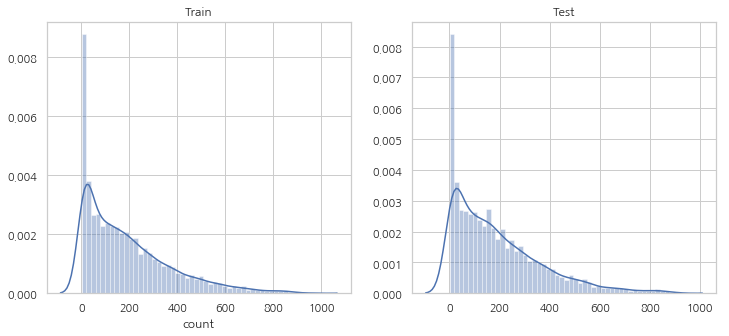

In [215]:
# 예측한 데이터를 시각화
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(Y_train, ax = ax1, bins=50) # 50개정도로 나눔
ax1.set(title = 'Train')
sns.distplot(pre, ax = ax2, bins = 50)
ax2.set(title = 'Test')

# Submission

In [216]:
submission = pd.read_csv("./data/bike-sharing-demand/sampleSubmission.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [217]:
submission['count'] = pre
submission.head()

,datetime,count
0,2011-01-20 00:00:00,12.13
1,2011-01-20 01:00:00,5.03
2,2011-01-20 02:00:00,4.40
3,2011-01-20 03:00:00,3.21
4,2011-01-20 04:00:00,2.92


In [218]:
submission.to_csv('./data/bike-sharing-demand/score-05.csv', index=False)

1.89404